# PeNSE 2015 Microdata Analysis

*   Author: Guilherme Camboim

## Imports and Installations

In [17]:
# Standard libraries
from datetime import datetime
from itertools import combinations

# NumPy, Pandas and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing and transformation
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering
from sklearn.cluster import KMeans

# Evaluation metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, pairwise_distances

# Distance calculations
from scipy.spatial.distance import cdist

# Statistical analysis
from scipy.stats import spearmanr, kendalltau, anderson, kurtosis, skew
from scipy import stats

# Association rule mining
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Other utilities
from google.colab import files

In [18]:
!pip install apyori

## Data consuming

In [19]:
!gdown '1L4qkbRyOkTva6in4hv7dUoFdsSH7jvp8'

Downloading...
From: https://drive.google.com/uc?id=1L4qkbRyOkTva6in4hv7dUoFdsSH7jvp8
To: /content/PENSE2015_MICRODADOS.CSV
100% 69.7M/69.7M [00:00<00:00, 76.8MB/s]


In [20]:
!gdown '1T_V5bQBqTJxWnI3punUBt_31WHs7-UkV'

Downloading...
From: https://drive.google.com/uc?id=1T_V5bQBqTJxWnI3punUBt_31WHs7-UkV
To: /content/Dicionario_PENSE2015_Microdados_Aluno.csv
100% 18.1k/18.1k [00:00<00:00, 33.1MB/s]


In [21]:
!gdown '1huVaeogDwkJabpUCUkZ6w5RzFJfvzsva'

Downloading...
From: https://drive.google.com/uc?id=1huVaeogDwkJabpUCUkZ6w5RzFJfvzsva
To: /content/Dicionario_PENSE2015_Microdados_Resposta_Alunos.csv
100% 34.7k/34.7k [00:00<00:00, 46.5MB/s]


## Data selection

In [22]:
df = pd.read_csv('/content/PENSE2015_MICRODADOS.CSV', delimiter=';')

In [23]:
df = df.drop(columns=["ANOPESQ","ESTRATOGEOREG","ESTRATO_EXP","PESO","aluno","escola","turma", "PAIS", "MUNICIPIO_CAP", "REGEOGR", "TIPO_MUNIC", "VB01004", "VB01005"])

# Removing columns about school questionary.
columns = [col for col in df.columns if not col.startswith('VE')]

df = df[columns]

# Selecting only students who are in the last year of primary school and students who are in the last year of high school.
df = df[df['VB01021'].isin([4, 7])]

In [24]:
# Removing the column referring to the student's level of education
df = df.drop(columns=['VB01021'])

In [25]:
df_dictionary = pd.read_csv('/content/Dicionario_PENSE2015_Microdados_Aluno.csv', delimiter=';')
dict_mapper_code_description = df_dictionary.set_index('Código')['Descrição'].to_dict()

In [26]:
df_answers = pd.read_csv('/content/Dicionario_PENSE2015_Microdados_Resposta_Alunos.csv', delimiter=';')

## Exploratory analysis


In [27]:
df.head(3)

,UFCENSO,VB00004,VB01001,VB01002,VB01003,VB01006,VB01007,VB01008A,VB01010A,VB01011,...,VB16001A03,VB16001A04,VB16001A05,VB16001A06,VB16001A07,VB16001A08,V0006,V0007,V0008,V0041
0,11,1,2,1,14,1,2,7,4,2,...,2,2,2,2,2,2,1,2,4,1
1,11,1,1,4,16,1,1,7,3,2,...,2,1,2,2,2,2,1,2,4,1
2,11,1,1,1,13,1,1,7,4,2,...,1,2,2,2,2,2,1,2,4,1


In [28]:
df.tail(3)

,UFCENSO,VB00004,VB01001,VB01002,VB01003,VB01006,VB01007,VB01008A,VB01010A,VB01011,...,VB16001A03,VB16001A04,VB16001A05,VB16001A06,VB16001A07,VB16001A08,V0006,V0007,V0008,V0041
102069,53,1,2,4,14,1,1,7,4,2,...,2,2,1,2,2,2,1,2,4,1
102070,53,1,1,4,15,2,1,7,3,2,...,2,2,1,2,2,2,1,2,4,1
102071,53,1,1,1,14,1,1,7,5,1,...,2,2,2,2,2,2,1,2,4,1


In [29]:
print(df.shape)

(100547, 164)


In [30]:
# Count: Number of non-zero values.
# Mean: Average value of the data.
# Standard deviation (std): Measure of the dispersion of the data in relation to the mean.
# Minimum (min): Minimum value found.
# 25% (25%): First quartile, that is, the value below which 25% of the data falls.
# Median (50%): The central value that divides the data into two halves.
# 75% (75%): Third quartile, where 75% of the data falls below this value.
# Maximum (max): Maximum value found.

pd.set_option('display.precision', 2)
df.describe()

,UFCENSO,VB00004,VB01001,VB01002,VB01003,VB01006,VB01007,VB01008A,VB01010A,VB01011,...,VB16001A03,VB16001A04,VB16001A05,VB16001A06,VB16001A07,VB16001A08,V0006,V0007,V0008,V0041
count,100547.00,100547.0,100547.00,100547.00,100547.00,100547.00,100547.00,100547.00,100547.00,100547.00,...,100547.00,100547.00,100547.00,100547.00,100547.00,100547.00,100547.00,100547.00,100547.00,100547.00
mean,29.13,1.0,1.52,2.84,14.33,1.17,1.48,5.42,4.56,1.96,...,2.68,2.57,2.36,2.68,2.69,2.74,1.08,1.21,2.72,-0.47
std,12.26,0.0,0.50,3.40,1.05,2.33,3.25,5.08,2.56,2.84,...,8.53,8.54,8.56,8.53,8.52,8.52,0.27,0.40,0.79,1.15
min,11.00,1.0,1.00,1.00,11.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-1.00
25%,21.00,1.0,1.00,1.00,14.00,1.00,1.00,3.00,3.00,2.00,...,2.00,2.00,1.00,2.00,2.00,2.00,1.00,1.00,2.00,-1.00
50%,27.00,1.0,2.00,3.00,14.00,1.00,1.00,5.00,4.00,2.00,...,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,3.00,-1.00
75%,35.00,1.0,2.00,4.00,15.00,1.00,2.00,7.00,5.00,2.00,...,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,3.00,-1.00
max,53.00,1.0,2.00,99.00,19.00,99.00,99.00,99.00,99.00,99.00,...,99.00,99.00,99.00,99.00,99.00,99.00,2.00,2.00,4.00,4.00


## Preprocessing

Normalizando os dados passíveis de normalização

In [31]:
duplicated = df.duplicated().sum()
print(f"\nTotal duplicate values: {duplicated}")


Total duplicate values: 19


In [32]:
df = df.drop_duplicates()

In [33]:
missing = df.isna().sum().sum()
print(f"\nTotal missing values: {missing}")


Total missing values: 1736


Normalizing data amenable to normalization

In [34]:
columns_to_normalize = ['TEMPODESLOC', 'TEMPOEDFIS', 'TEMPOEXTRA', 'TEMPOTOTAL', 'TEMPOEST']

imputer = SimpleImputer(strategy='mean')

df[columns_to_normalize] = imputer.fit_transform(df[columns_to_normalize])

normalizer = Normalizer()

df[columns_to_normalize] = normalizer.fit_transform(df[columns_to_normalize])
df[columns_to_normalize]

,TEMPODESLOC,TEMPOEDFIS,TEMPOEXTRA,TEMPOTOTAL,TEMPOEST
0,0.71,0.00,0.00,0.71,0.00
1,0.14,0.06,0.51,0.71,0.47
2,0.00,0.00,0.51,0.51,0.69
3,0.06,0.05,0.55,0.66,0.51
4,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...
102067,0.00,0.00,0.00,0.00,0.00
102068,0.00,0.26,0.52,0.78,0.24
102069,0.00,0.71,0.00,0.71,0.00
102070,0.00,0.18,0.58,0.77,0.20


## Data visualization

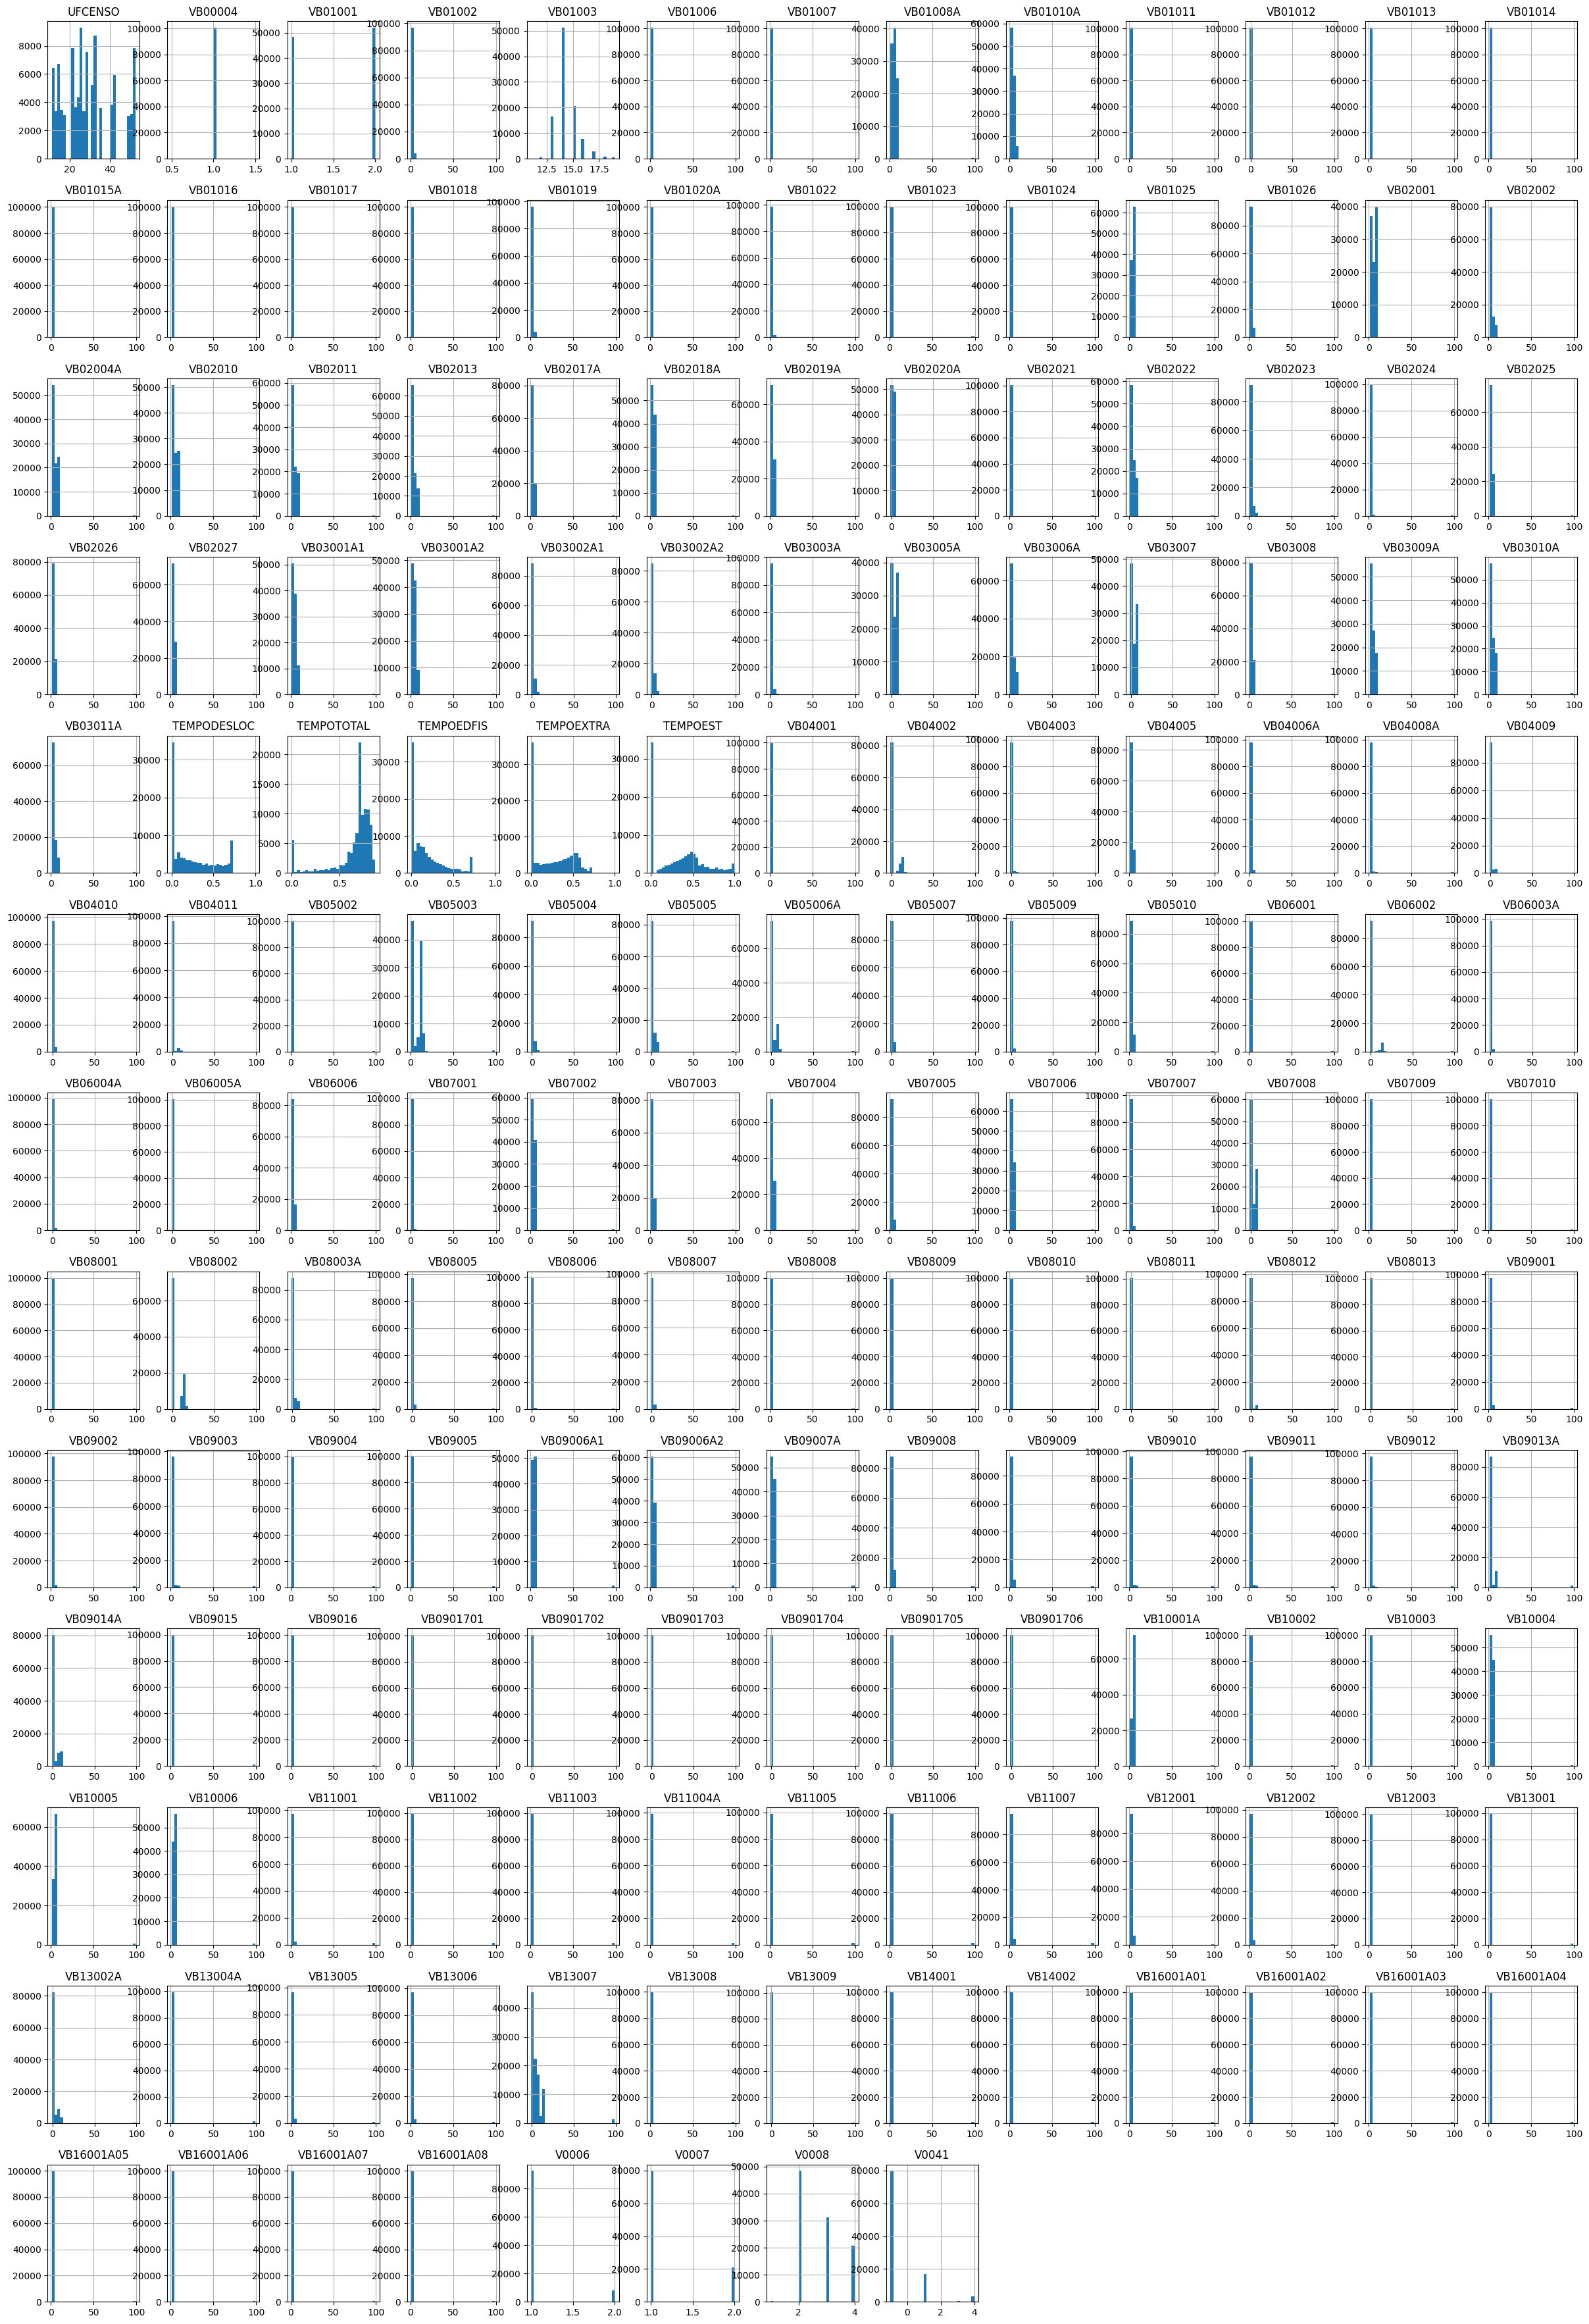

In [35]:
df.hist(figsize=(30,45),bins=30)
plt.show()

## Defining the size of "k" for Clustering

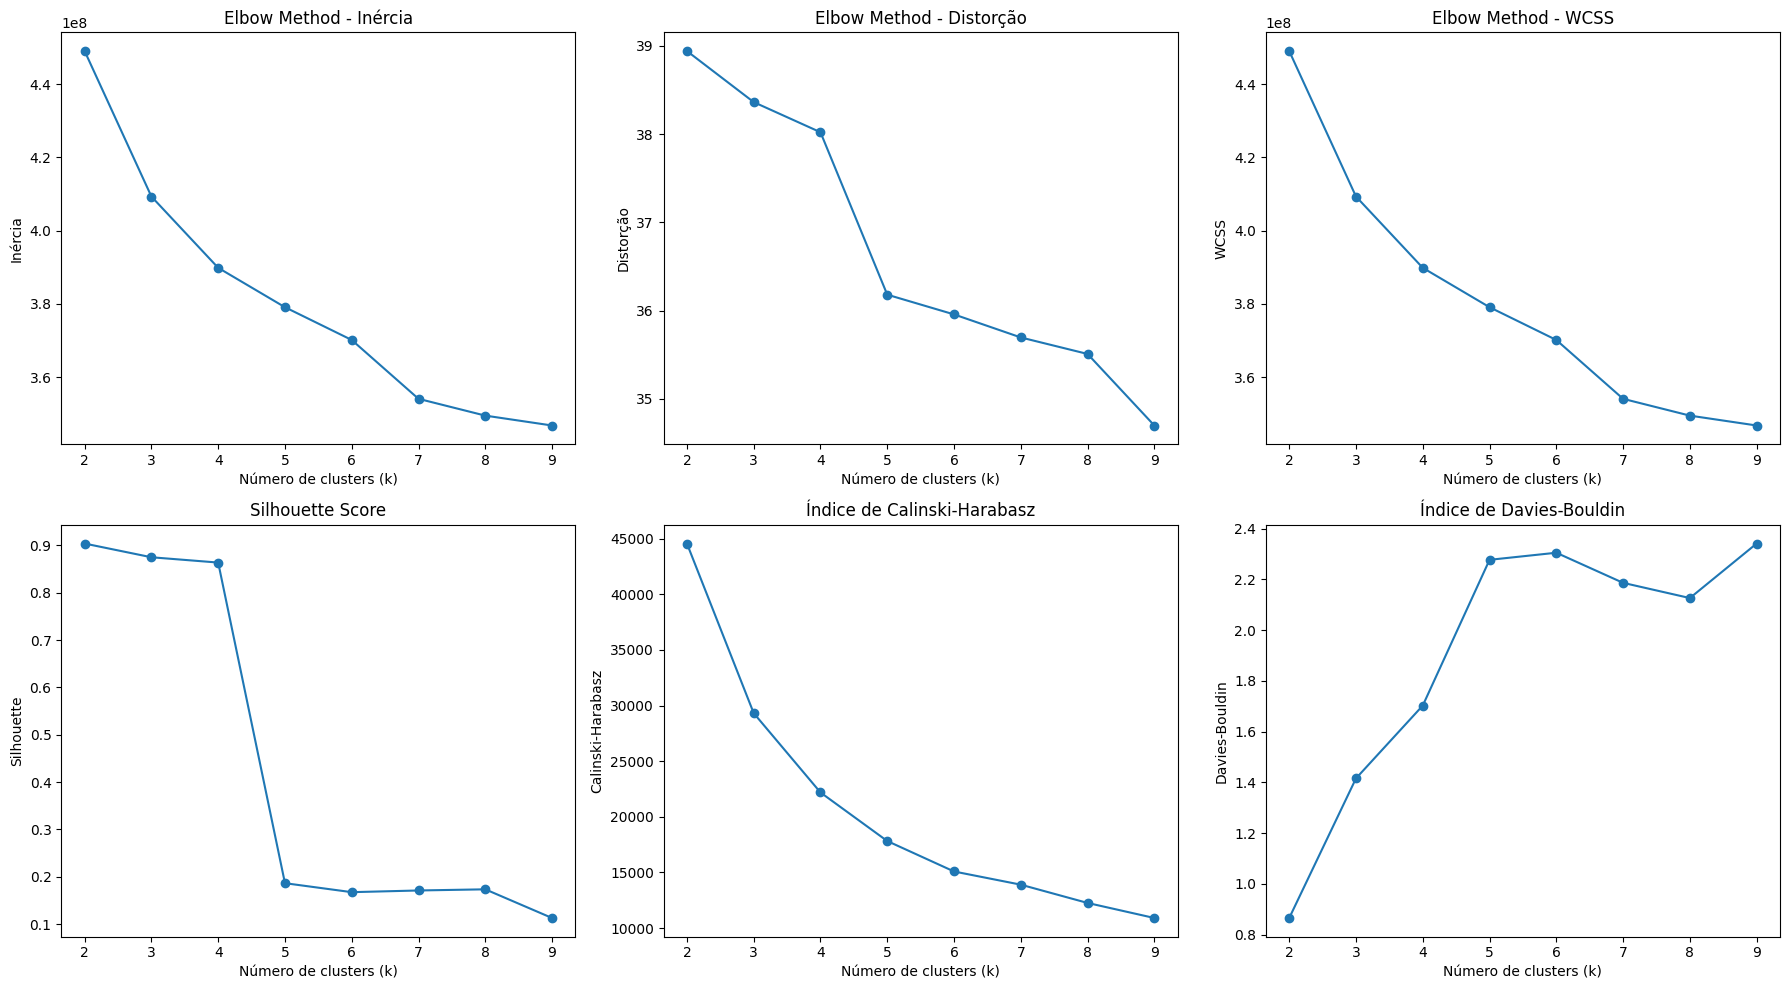

Elbow (inertia): 3
Elbow (WCSS): 3
Elbow (distorção): 5
Melhor k pelo Silhouette Score: 2
Melhor k pelo Calinski-Harabasz Index: 2
Melhor k pelo Davies-Bouldin Index: 2


In [43]:
def detect_elbow_by_max_distance(x, y):
    x_arr = np.array(x, dtype=float)
    y_arr = np.array(y, dtype=float)

    y_norm = (y_arr - y_arr.min()) / (y_arr.max() - y_arr.min())
    points = np.vstack([x_arr, y_norm]).T
    start = points[0]
    end = points[-1]

    def point_line_distance(pt, a, b):
        ba = b - a
        pa = a - pt
        cross_val = ba[0] * pa[1] - ba[1] * pa[0]
        return np.abs(cross_val) / np.linalg.norm(ba)

    distances = np.array([point_line_distance(p, start, end) for p in points])
    elbow_idx = np.argmax(distances)
    return x_arr[elbow_idx]

def detect_elbow_by_pct_change(x, y):
    y_arr = np.array(y, dtype=float)
    if len(y_arr) < 2:
        return x[0]
    deltas = np.diff(y_arr)
    pct_change = np.abs(deltas / y_arr[:-1])
    best_idx = np.argmax(pct_change) + 1
    return x[best_idx]

inertia = []
distorcao = []
wcss = []
silhouette = []
calinski = []
davies = []

K = list(range(2, 10))

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)

    labels = kmeans.labels_

    inertia.append(kmeans.inertia_)
    dist = np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)
    distorcao.append(np.mean(dist))
    wcss.append(np.sum(dist**2))
    silhouette.append(silhouette_score(df, labels))
    calinski.append(calinski_harabasz_score(df, labels))
    davies.append(davies_bouldin_score(df, labels))

best_k_inertia_elbow = detect_elbow_by_max_distance(K, inertia)
best_k_inertia_pct = detect_elbow_by_pct_change(K, inertia)

best_k_wcss_elbow = detect_elbow_by_max_distance(K, wcss)
best_k_wcss_pct = detect_elbow_by_pct_change(K, wcss)

best_k_distorcao_elbow = detect_elbow_by_max_distance(K, distorcao)
best_k_distorcao_pct = detect_elbow_by_pct_change(K, distorcao)

best_k_silhouette = K[np.argmax(silhouette)]
best_k_calinski = K[np.argmax(calinski)]
best_k_davies = K[np.argmin(davies)]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0, 0].plot(K, inertia, marker='o')
axs[0, 0].set_xlabel("Número de clusters (k)")
axs[0, 0].set_ylabel("Inércia")
axs[0, 0].set_title("Elbow Method - Inércia")

axs[0, 1].plot(K, distorcao, marker='o')
axs[0, 1].set_xlabel("Número de clusters (k)")
axs[0, 1].set_ylabel("Distorção")
axs[0, 1].set_title("Elbow Method - Distorção")

axs[0, 2].plot(K, wcss, marker='o')
axs[0, 2].set_xlabel("Número de clusters (k)")
axs[0, 2].set_ylabel("WCSS")
axs[0, 2].set_title("Elbow Method - WCSS")

axs[1, 0].plot(K, silhouette, marker='o')
axs[1, 0].set_xlabel("Número de clusters (k)")
axs[1, 0].set_ylabel("Silhouette")
axs[1, 0].set_title("Silhouette Score")

axs[1, 1].plot(K, calinski, marker='o')
axs[1, 1].set_xlabel("Número de clusters (k)")
axs[1, 1].set_ylabel("Calinski-Harabasz")
axs[1, 1].set_title("Índice de Calinski-Harabasz")

axs[1, 2].plot(K, davies, marker='o')
axs[1, 2].set_xlabel("Número de clusters (k)")
axs[1, 2].set_ylabel("Davies-Bouldin")
axs[1, 2].set_title("Índice de Davies-Bouldin")

plt.tight_layout()
plt.show()

print(f"Elbow (inertia): {best_k_inertia_pct}")
print(f"Elbow (WCSS): {best_k_wcss_pct}")
print(f"Elbow (distorção): {best_k_distorcao_pct}")
print(f"Melhor k pelo Silhouette Score: {best_k_silhouette}")
print(f"Melhor k pelo Calinski-Harabasz Index: {best_k_calinski}")
print(f"Melhor k pelo Davies-Bouldin Index: {best_k_davies}")

## Clustering

### k = 2

In [36]:
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300, random_state=42)
labels = kmeans.fit_predict(df)

df["cluster"] = labels
df.groupby("cluster").describe()

UFCENSO                                              VB00004       \
           count   mean    std   min   25%   50%   75%   max    count mean   
cluster                                                                      
0        99709.0  29.13  12.26  11.0  21.0  27.0  35.0  53.0  99709.0  1.0   
1          819.0  29.27  12.61  11.0  21.0  26.0  38.0  53.0    819.0  1.0   

         ... V0008         V0041                                       
         ...   75%  max    count  mean   std  min  25%  50%  75%  max  
cluster  ...                                                           
0        ...   3.0  4.0  99709.0 -0.47  1.15 -1.0 -1.0 -1.0 -1.0  4.0  
1        ...   3.0  4.0    819.0 -0.83  0.71 -1.0 -1.0 -1.0 -1.0  4.0  

[2 rows x 1312 columns]

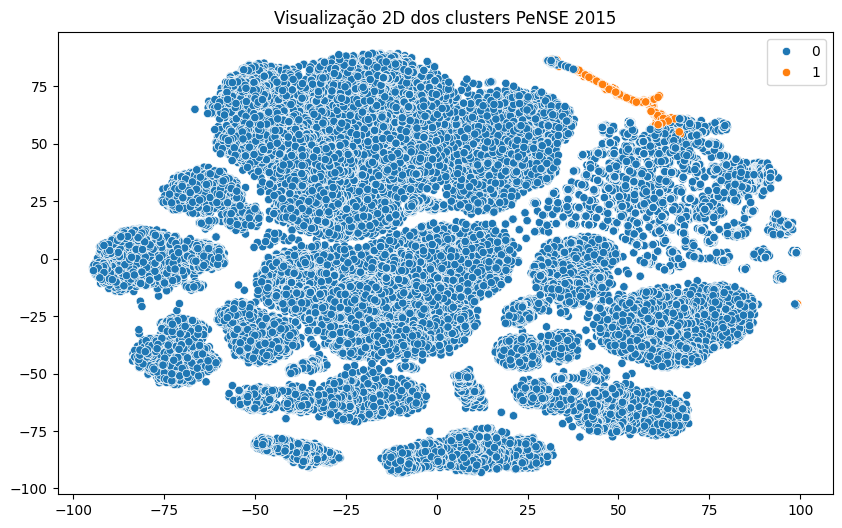

In [37]:
X = df.values

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10')
plt.title("Visualização 2D dos clusters PeNSE 2015")
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


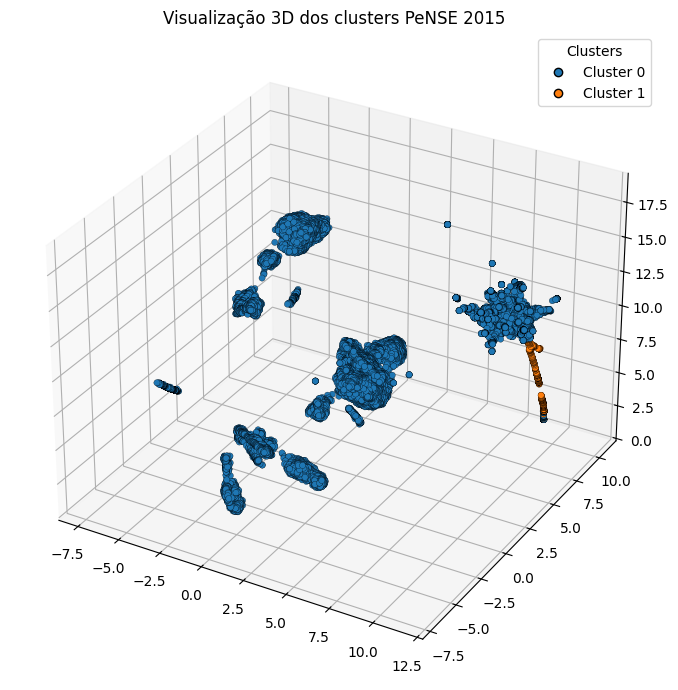

In [38]:
reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = reducer.fit_transform(df)

color_map = {
    0: '#1f77b4',  # blue
    1: '#ff7f0e',  # orange
}

colors = [color_map[label] for label in labels]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
    c=colors,
    s=20,
    alpha=1.0,
    edgecolor='k',
    linewidth=0.2
)

from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=color_map[i], markersize=6, markeredgecolor='k')
    for i in sorted(np.unique(labels))
]
ax.legend(handles=handles, title="Clusters")

ax.set_title("Visualização 3D dos clusters PeNSE 2015")
plt.tight_layout()
plt.show()

### k = 5

In [39]:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300, random_state=42)
labels = kmeans.fit_predict(df)

df["cluster"] = labels
df.groupby("cluster").describe()

UFCENSO                                              VB00004       \
           count   mean    std   min   25%   50%   75%   max    count mean   
cluster                                                                      
0          655.0  30.63  12.69  11.0  21.0  28.0  41.0  53.0    655.0  1.0   
1        98986.0  29.12  12.25  11.0  21.0  27.0  35.0  53.0  98986.0  1.0   
2          207.0  30.00  11.96  12.0  22.0  28.0  38.0  53.0    207.0  1.0   
3          390.0  29.52  13.13  11.0  21.0  26.0  41.0  53.0    390.0  1.0   
4          290.0  29.81  12.92  11.0  21.0  26.5  41.0  53.0    290.0  1.0   

         ... V0008         V0041                                       
         ...   75%  max    count  mean   std  min  25%  50%  75%  max  
cluster  ...                                                           
0        ...   3.0  4.0    655.0 -0.71  0.91 -1.0 -1.0 -1.0 -1.0  4.0  
1        ...   3.0  4.0  98986.0 -0.47  1.15 -1.0 -1.0 -1.0 -1.0  4.0  
2        ...   3.0  4.0    207.0 -0.83  0.73 -1.0 -1.0 -1.0 -1.0  4.0  
3        ...   3.0  4.0    390.0 -0.78  0.83 -1.0 -1.0 -1.0 -1.0  4.0  
4        ...   3.0  4.0    290.0 -0.84  0.63 -1.0 -1.0 -1.0 -1.0  4.0  

[5 rows x 1312 columns]

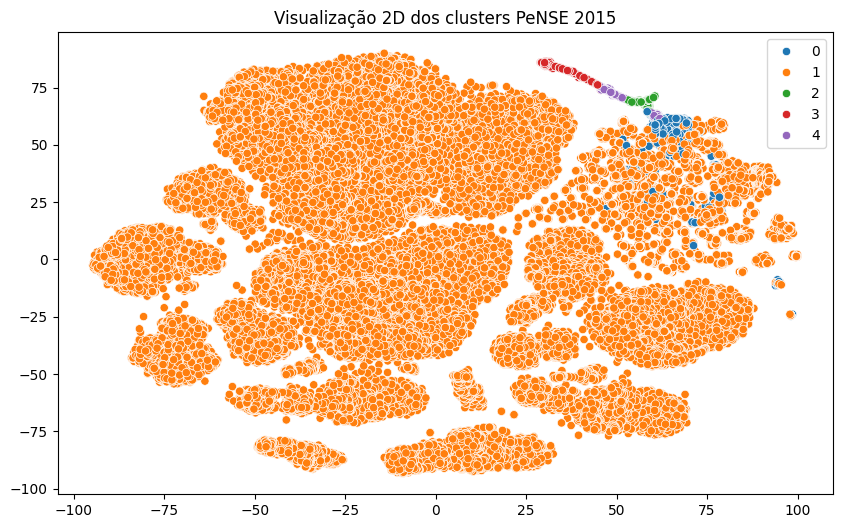

In [40]:
X = df.values

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10')
plt.title("Visualização 2D dos clusters PeNSE 2015")
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


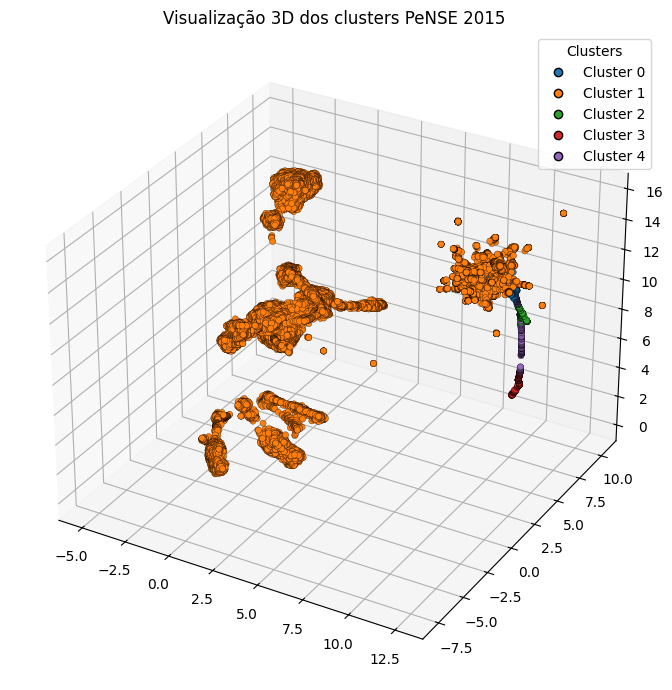

In [42]:
reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = reducer.fit_transform(df)

color_map = {
    0: '#1f77b4',  # blue
    1: '#ff7f0e',  # orange
    2: '#2ca02c',  # green
    3: '#d62728',  # red
    4: '#9467bd',  # purple
}

colors = [color_map[label] for label in labels]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
    c=colors,
    s=20,
    alpha=1.0,
    edgecolor='k',
    linewidth=0.2
)

from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=color_map[i], markersize=6, markeredgecolor='k')
    for i in sorted(np.unique(labels))
]
ax.legend(handles=handles, title="Clusters")

ax.set_title("Visualização 3D dos clusters PeNSE 2015")
plt.tight_layout()
plt.show()

### k = 3

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=300, random_state=42)
labels = kmeans.fit_predict(df)

df["cluster"] = labels
df.groupby("cluster").describe()

UFCENSO                                               VB00004       \
           count   mean    std   min    25%   50%   75%   max    count mean   
cluster                                                                       
0        99423.0  29.13  12.25  11.0  21.00  27.0  35.0  53.0  99423.0  1.0   
1          751.0  29.43  12.85  11.0  21.00  26.0  41.0  53.0    751.0  1.0   
2          354.0  29.96  12.27  12.0  21.25  28.0  41.0  53.0    354.0  1.0   

         ... V0008         V0041                                       
         ...   75%  max    count  mean   std  min  25%  50%  75%  max  
cluster  ...                                                           
0        ...   3.0  4.0  99423.0 -0.47  1.15 -1.0 -1.0 -1.0 -1.0  4.0  
1        ...   3.0  4.0    751.0 -0.76  0.86 -1.0 -1.0 -1.0 -1.0  4.0  
2        ...   3.0  4.0    354.0 -0.84  0.68 -1.0 -1.0 -1.0 -1.0  4.0  

[3 rows x 1312 columns]

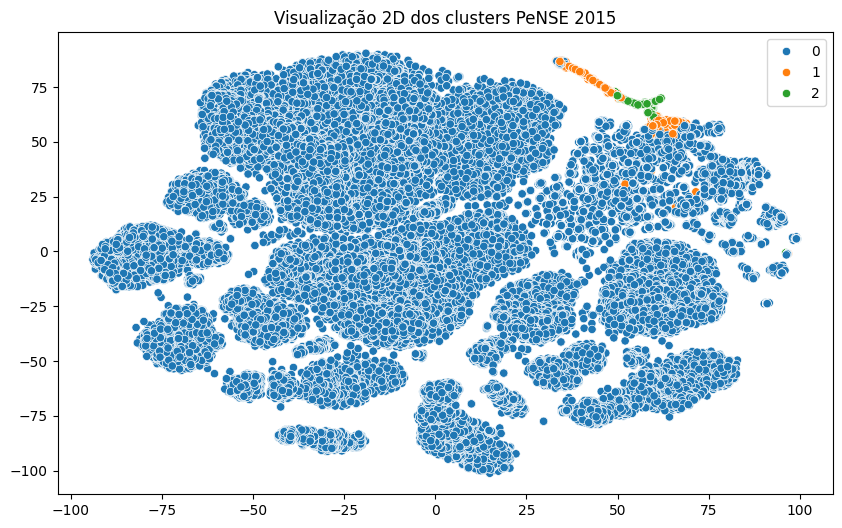

In [ ]:
X = df.values

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab10')
plt.title("Visualização 2D dos clusters PeNSE 2015")
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


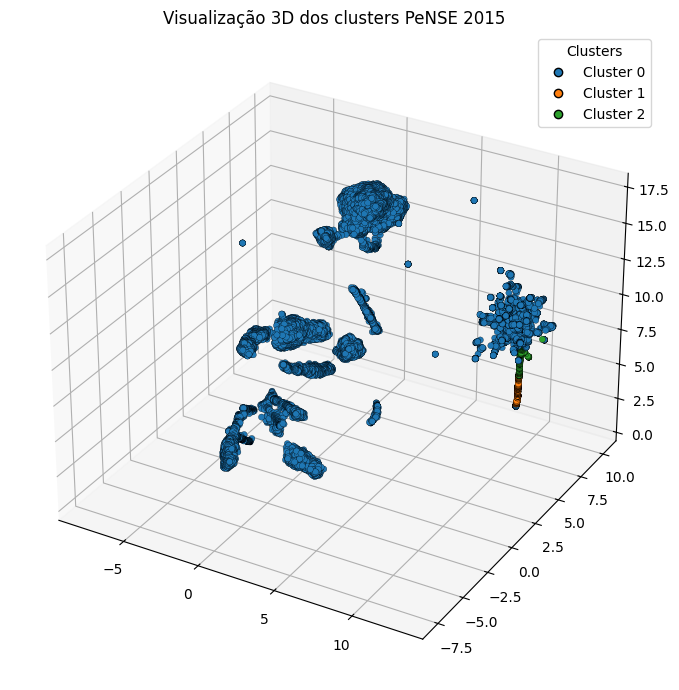

In [ ]:
reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = reducer.fit_transform(df)

color_map = {
    0: '#1f77b4',  # blue
    1: '#ff7f0e',  # orange
    2: '#2ca02c',  # green
}

colors = [color_map[label] for label in labels]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
    c=colors,
    s=20,
    alpha=1.0,
    edgecolor='k',
    linewidth=0.2
)

from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=color_map[i], markersize=6, markeredgecolor='k')
    for i in sorted(np.unique(labels))
]
ax.legend(handles=handles, title="Clusters")

ax.set_title("Visualização 3D dos clusters PeNSE 2015")
plt.tight_layout()
plt.show()

In [ ]:
adminstrative_type_and_cod_uf_mode = df.groupby('cluster')[['V0008', 'UFCENSO']].agg(lambda x: x.mode().iloc[0]).reset_index()
adminstrative_type_and_cod_uf_mode

,cluster,V0008,UFCENSO
0,0,2,52
1,1,2,22
2,2,2,35


In [ ]:
administrative_type_and_cod_uf_dictionary = df_answers.query('Variável == "V0008" | Variável == "UFCENSO"')
administrative_type_and_cod_uf_dictionary

,Variável,Código,Descrição
6,UFCENSO,11,Rondônia
7,UFCENSO,12,Acre
8,UFCENSO,13,Amazonas
9,UFCENSO,14,Roraima
10,UFCENSO,15,Para
11,UFCENSO,16,Amapá
12,UFCENSO,17,Tocantins
13,UFCENSO,21,Maranhão
14,UFCENSO,22,Piauí
15,UFCENSO,23,Ceará


#### Apriori algorithm

In [ ]:
time_columns = ['TEMPODESLOC', 'TEMPOEDFIS', 'TEMPOEXTRA', 'TEMPOTOTAL']

columns_to_categorize = time_columns

for col in columns_to_categorize:
    ruido = np.random.normal(0, 1e-6, size=len(df[col]))
    df[col] = pd.qcut(df[col] + ruido, q=3, labels=[0, 1, 2]).astype(int)

description_df = df_answers.copy()
description_df = description_df[~description_df['Variável'].isin(time_columns)]
description_df['Código'] = description_df['Código'].astype(float)
df_description_copy = description_df.copy()
categoric_df = df.copy()

mapper = {}

for _, row in df_description_copy.iterrows():
    variable = row['Variável']

    try:
        code = int(float(row['Código']))
    except (ValueError, TypeError):
        continue

    descricao = row['Descrição']

    if variable not in mapper:
        mapper[variable] = {}

    mapper[variable][code] = descricao

for columns in categoric_df.columns:
    if columns in mapper:
        categoric_df[columns] = categoric_df[columns].map(mapper[columns]).fillna(categoric_df[columns])


time_mapper = {0: 'Médio', 1: 'Baixo', 2: 'Alto'}

categoric_df[time_columns] = categoric_df[time_columns].replace(time_mapper)

categoric_df['IDEB'] = categoric_df['cluster'].map({0: "Alto", 1: "Baixo"})

categoric_df = categoric_df.rename(columns=dict_mapper_code_description)

/tmp/ipython-input-2613577736.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categoric_df['IDEB'] = categoric_df['cluster'].map({0: "Alto", 1: "Baixo"})


In [ ]:
data = categoric_df.astype(str)
transactions = data.apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1).tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_binario = pd.DataFrame(te_ary, columns=te.columns_)


frequent_itemsets = apriori(
    df_binario,
    min_support=0.25,
    use_colnames=True,
    max_len=2
)


rules = association_rules(
    frequent_itemsets,
    metric='confidence',
    min_threshold=0.75
)

apriori_rules = rules[
    (rules['lift'] > 1.5) &
    (rules['confidence'] > 0.75) &
    (rules['support'] > 0.2) &
    (rules['conviction'] > 1.2)
]


apriori_rules = apriori_rules[
    ~apriori_rules['antecedents'].astype(str).str.contains("pulo no questionário", case=False, na=False) &
    ~apriori_rules['consequents'].astype(str).str.contains("pulo no questionário", case=False, na=False)
]

apriori_rules = apriori_rules.sort_values(by=['lift', 'confidence'], ascending=False)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


## Association rules and Correlation statistics

### Correlational Statistical Analysis

Inserting IDEB values into clusters to analyse correlation with variables

In [ ]:
numeric_df = df.copy()
numeric_df['cluster'] = numeric_df['cluster'].map({
    0: 4.25, # Estadual Goiás
    1: 3.50, # Estadual Piauí
    2: 4.3, # Estadual São Paulo
    })

numeric_df = numeric_df.rename(columns={'cluster': 'IDEB'})

for col in numeric_df.columns:
    if not pd.api.types.is_numeric_dtype(numeric_df[col]) or col == 'IDEB':
        continue

    col_vals = numeric_df[col]

    if 99 in col_vals.values:
        numeric_df.loc[numeric_df[col] == 99, col] = np.nan
    else:
        max_val = col_vals.max()
        if max_val <= 9:
            numeric_df.loc[numeric_df[col] == max_val, col] = np.nan

    if numeric_df[col].isnull().any():
        moda = numeric_df[col].mode(dropna=True)
        if not moda.empty:
            numeric_df[col] = numeric_df[col].fillna(moda[0])

Dividing variables according their distribuition (normal or non normal)

In [ ]:
def assess_normality(series, skew_thresh=0.5, kurtosis_excess_thresh=0.5):
    s = series.dropna()
    if len(s) < 30:
        return {"approx_normal": False, "skew": np.nan, "excess_kurtosis": np.nan, "n": len(s)}
    skew_val = skew(s)
    excess_kurtosis = kurtosis(s, fisher=True)
    approx_normal = (abs(skew_val) <= skew_thresh) and (abs(excess_kurtosis) <= kurtosis_excess_thresh)
    return {
        "approx_normal": approx_normal,
        "skew": skew_val,
        "excess_kurtosis": excess_kurtosis,
        "n": len(s)
    }

def identify_normal_columns(df, skew_thresh=0.5, kurtosis_excess_thresh=0.5):
    normal = []
    non_normal = []
    details = {}
    for col in df.select_dtypes(include=[np.number]).columns:
        res = assess_normality(df[col], skew_thresh, kurtosis_excess_thresh)
        details[col] = res
        if res["approx_normal"]:
            normal.append(col)
        else:
            non_normal.append(col)

    if "IDEB" in df.columns:
        if "IDEB" not in normal:
            normal.append("IDEB")
        if "IDEB" not in non_normal:
            non_normal.append("IDEB")
    summary_df = pd.DataFrame.from_dict(details, orient="index")
    return normal, non_normal, summary_df

normal_cols, non_normal_cols, summary_df = identify_normal_columns(numeric_df, skew_thresh=0.7, kurtosis_excess_thresh=1.0)
print("Colunas aproximadamente normais:", normal_cols)
print("Colunas não normais:", non_normal_cols)

/tmp/ipython-input-1957538143.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(s)
/tmp/ipython-input-1957538143.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  excess_kurtosis = kurtosis(s, fisher=True)


Colunas aproximadamente normais: ['UFCENSO', 'VB01026', 'VB02013', 'VB02025', 'VB02026', 'VB02027', 'VB03006A', 'VB03009A', 'TEMPOEST', 'VB05010', 'VB09015', 'VB10002', 'VB11001', 'VB12001', 'VB12002', 'VB13007', 'IDEB']
Colunas não normais: ['VB00004', 'VB01001', 'VB01002', 'VB01003', 'VB01006', 'VB01007', 'VB01008A', 'VB01010A', 'VB01011', 'VB01012', 'VB01013', 'VB01014', 'VB01015A', 'VB01016', 'VB01017', 'VB01018', 'VB01019', 'VB01020A', 'VB01022', 'VB01023', 'VB01024', 'VB01025', 'VB02001', 'VB02002', 'VB02004A', 'VB02010', 'VB02011', 'VB02017A', 'VB02018A', 'VB02019A', 'VB02020A', 'VB02021', 'VB02022', 'VB02023', 'VB02024', 'VB03001A1', 'VB03001A2', 'VB03002A1', 'VB03002A2', 'VB03003A', 'VB03005A', 'VB03007', 'VB03008', 'VB03010A', 'VB03011A', 'TEMPODESLOC', 'TEMPOTOTAL', 'TEMPOEDFIS', 'TEMPOEXTRA', 'VB04001', 'VB04002', 'VB04003', 'VB04005', 'VB04006A', 'VB04008A', 'VB04009', 'VB04010', 'VB04011', 'VB05002', 'VB05003', 'VB05004', 'VB05005', 'VB05006A', 'VB05007', 'VB05009', 'VB06

Function to evaluate correlation results

In [ ]:
def interpret_correlation(variable, description, coef):
    abs_coef = abs(coef)
    direction = "positiva" if coef > 0 else "negativa"

    if abs_coef < 0.2:
        intensity = "muito fraca"
    elif abs_coef < 0.4:
        intensity = "fraca"
    elif abs_coef < 0.6:
        intensity = "moderada"
    elif abs_coef < 0.8:
        intensity = "forte"
    else:
        intensity = "muito forte"

    text = (
        f"A variável **{variable}** ({description}) apresenta uma correlação {direction} "
        f"{intensity} ({coef:.2%}) com o IDEB. "
    )

    if coef < 0:
        text += "Isso sugere que quanto maior o valor dessa variável, menor tende a ser o IDEB."
    else:
        text += "Isso sugere que quanto maior o valor dessa variável, maior tende a ser o IDEB."

    return text

#### Pearson

In [ ]:
corr_pearson = numeric_df[normal_cols].corr(method='pearson')
target_var = 'IDEB'

correlation_with_target_pearson = corr_pearson[target_var].drop(labels=[target_var])

ordered_correlations = correlation_with_target_pearson.abs().sort_values(ascending=False)

top_10_indices = ordered_correlations.index[:10]

top_10_pearson_relation = pd.DataFrame({
    'Variável': top_10_indices,
    'Correlação': correlation_with_target_pearson[top_10_indices].values
})

top_10_pearson_relation['Descrição'] = top_10_pearson_relation['Variável'].map(dict_mapper_code_description)

top_10_pearson_relation['Interpretação'] = top_10_pearson_relation.apply(
    lambda row: interpret_correlation(row['Variável'], row['Descrição'], row['Correlação']), axis=1
)

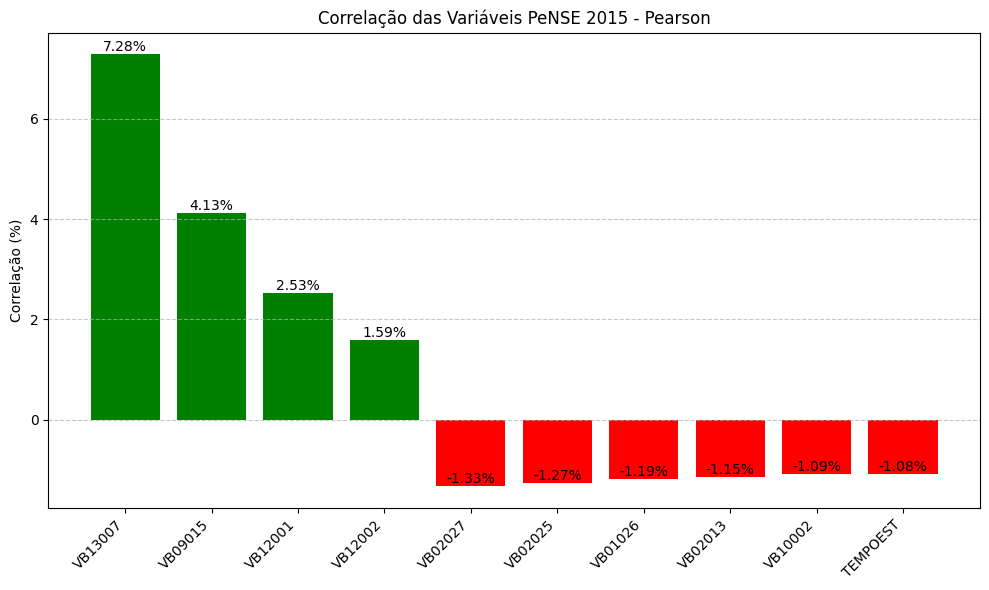

In [ ]:
top_10_pearson_relation_percentage = top_10_pearson_relation["Correlação"] * 100
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_pearson_relation["Variável"], top_10_pearson_relation_percentage,
               color=["green" if x > 0 else "red" for x in top_10_pearson_relation_percentage])

plt.xticks(rotation=45, ha="right")
plt.ylabel("Correlação (%)")
plt.title("Correlação das Variáveis PeNSE 2015 - Pearson")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.2f}%",
             ha="center", va="bottom")

plt.tight_layout()
plt.show()

#### Spearman

In [ ]:
df_encoded = numeric_df.copy()

for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

cor_spearman = df_encoded[non_normal_cols].corr(method='spearman')
target_var = 'IDEB'

correlation_with_target_spearman = cor_spearman[target_var].drop(labels=[target_var])

ordered_correlations = correlation_with_target_spearman.abs().sort_values(ascending=False)

top_10_indices_spearman = ordered_correlations.index[:10]

top_10_spearman_relation = pd.DataFrame({
    'Variável': top_10_indices_spearman,
    'Correlação': correlation_with_target_spearman[top_10_indices_spearman].values
})

top_10_spearman_relation['Descrição'] = top_10_spearman_relation['Variável'].map(dict_mapper_code_description)

top_10_spearman_relation['Interpretação'] = top_10_spearman_relation.apply(
    lambda row: interpret_correlation(row['Variável'], row['Descrição'], row['Correlação']), axis=1
)

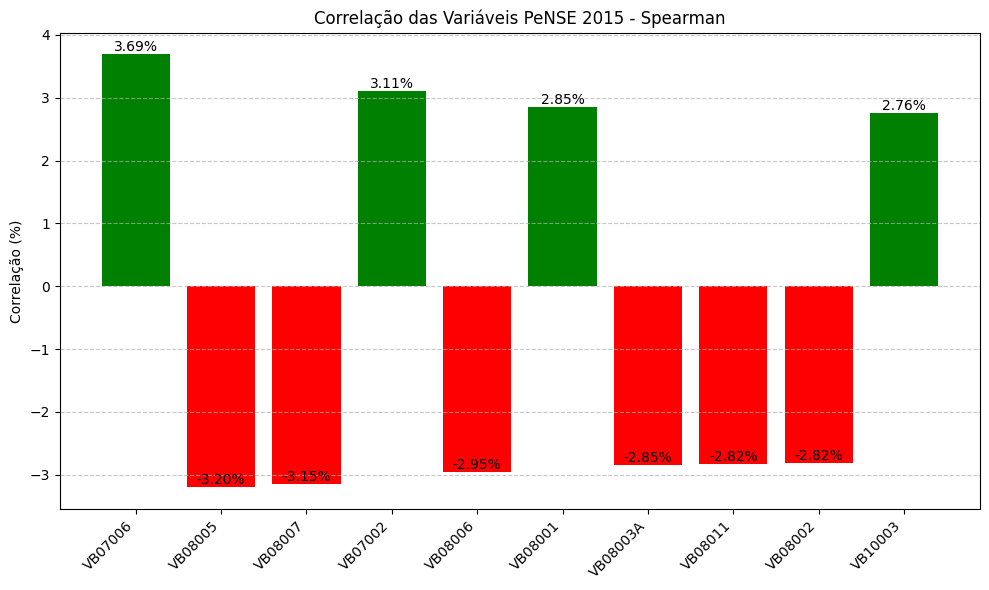

In [ ]:
top_10_spearman_relation_percentage = top_10_spearman_relation["Correlação"] * 100
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_spearman_relation["Variável"], top_10_spearman_relation_percentage,
               color=["green" if x > 0 else "red" for x in top_10_spearman_relation_percentage])

plt.xticks(rotation=45, ha="right")
plt.ylabel("Correlação (%)")
plt.title("Correlação das Variáveis PeNSE 2015 - Spearman")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.2f}%",
             ha="center", va="bottom")

plt.tight_layout()
plt.show()

#### Kendall

In [ ]:
cor_kendall = df_encoded[non_normal_cols].corr(method='kendall')
target_var = 'IDEB'

correlation_with_target_kendall = cor_kendall[target_var].drop(labels=[target_var])

ordered_correlations = correlation_with_target_kendall.abs().sort_values(ascending=False)

top_10_indices_kendall = ordered_correlations.index[:10]

top_10_kendall_relation = pd.DataFrame({
    'Variável': top_10_indices_kendall,
    'Correlação': correlation_with_target_kendall[top_10_indices_kendall].values
})

top_10_kendall_relation['Descrição'] = top_10_kendall_relation['Variável'].map(dict_mapper_code_description)

top_10_kendall_relation['Interpretação'] = top_10_kendall_relation.apply(
    lambda row: interpret_correlation(row['Variável'], row['Descrição'], row['Correlação']), axis=1
)

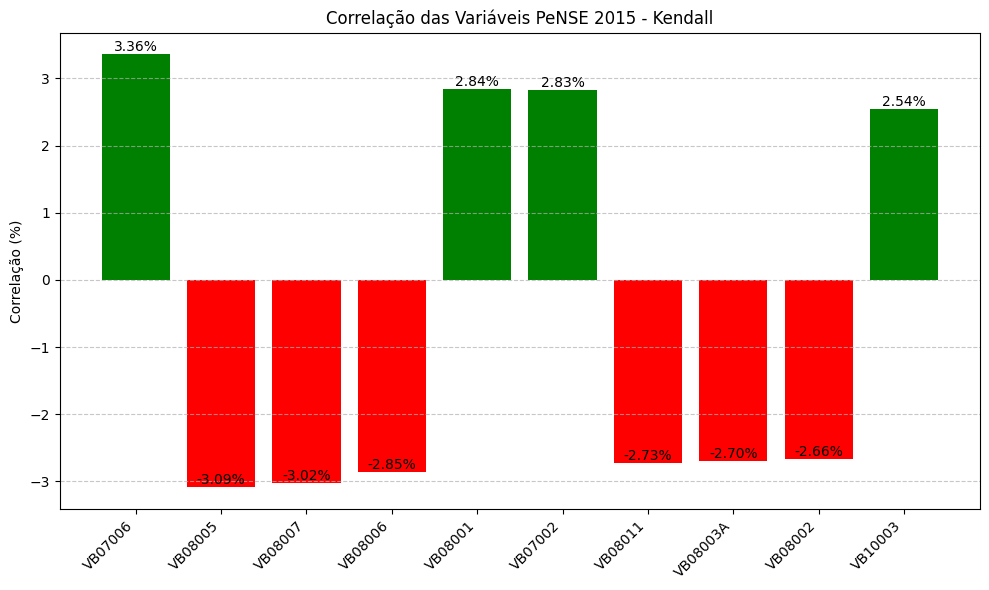

In [ ]:
top_10_kendall_relation_percentage = top_10_kendall_relation["Correlação"] * 100
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_kendall_relation["Variável"], top_10_kendall_relation_percentage,
               color=["green" if x > 0 else "red" for x in top_10_kendall_relation_percentage])

plt.xticks(rotation=45, ha="right")
plt.ylabel("Correlação (%)")
plt.title("Correlação das Variáveis PeNSE 2015 - Kendall")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.2f}%",
             ha="center", va="bottom")

plt.tight_layout()
plt.show()

## Categoric Datasets to Interpret

In [ ]:
df_without_negative_values = df.mask((df < 0) | (df == 99))

df_with_mode_of_variables = []

for cluster_num in df_without_negative_values['cluster'].unique():
    df_cluster = df_without_negative_values[df_without_negative_values['cluster'] == cluster_num]

    df_cluster_without_negative_values = df_cluster.drop(columns=['cluster'])
    tabela_moda_cluster = pd.DataFrame({
        "Variável": df_cluster_without_negative_values.columns,
        "Valor Mais Frequente": [df_cluster_without_negative_values[col].mode().iloc[0] for col in df_cluster_without_negative_values.columns],
        "Cluster": cluster_num
    })

    df_with_mode_of_variables.append(tabela_moda_cluster)

df_with_mode_of_variables_treated = pd.concat(df_with_mode_of_variables, ignore_index=True)

df_interpretative = pd.merge(df_with_mode_of_variables_treated, df_dictionary, left_on='Variável', right_on='Código', how='left')
df_interpretative = df_interpretative[['Variável','Descrição', 'Valor Mais Frequente', 'Cluster']]
df_interpretative["Valor Mais Frequente"] = df_interpretative["Valor Mais Frequente"].apply(
    lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else str(x))
df_interpretative['CONCAT'] = df_interpretative['Variável'].astype(str) + df_interpretative['Valor Mais Frequente'].astype(str)
df_answers['CONCAT'] = df_answers['Variável'].astype(str) + df_answers['Código'].astype(str)
df_interpretative = df_interpretative.merge(df_answers[["CONCAT", "Descrição"]], on="CONCAT", how="left", suffixes=("", "_t2"))
df_interpretative["Valor Mais Frequente"] = df_interpretative["Descrição_t2"]
df_interpretative.drop(columns=["Descrição_t2"], inplace=True)


Associating IDEB values to dataset

In [ ]:
ideb_map = {
    "Goiás": 4.25, # Estadual
    "Piauí": 3.50, # Estadual
    "São Paulo": 4.3, # Estadual
}

state_by_cluster = df_interpretative[df_interpretative['Variável'] == 'UFCENSO'].set_index('Cluster')['Valor Mais Frequente'].to_dict()

df_interpretative['IDEB'] = df_interpretative['Cluster'].map(state_by_cluster).map(ideb_map)

Creating dataset with only divergent variables

In [ ]:
df_differences_items = df_interpretative.groupby('Variável')['Valor Mais Frequente'].nunique()
variables_with_diference = df_differences_items[df_differences_items > 1].index

df_with_only_different_values_by_varibles = df_interpretative[df_interpretative['Variável'].isin(variables_with_diference)].sort_values(['Variável', 'Cluster'])

## Download Section

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"PeNSE2015_analise_completa_{timestamp}.xlsx"

with pd.ExcelWriter(filename) as writer:
    df_interpretative.to_excel(writer, sheet_name='Clusterizacao_Completa', index=False)
    df_with_only_different_values_by_varibles.to_excel(writer, sheet_name='Diferencas_Clusters', index=False)
    top_10_spearman_relation.to_excel(writer, sheet_name='Spearman', index=False)
    top_10_pearson_relation.to_excel(writer, sheet_name='Pearson', index=False)
    top_10_kendall_relation.to_excel(writer, sheet_name='Kendal', index=False)
    apriori_rules.to_excel(writer, sheet_name='Regras_Associacao', index=False)
    df_answers.to_excel(writer, sheet_name='Dicionario', index=False)

files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>